# Dynamic reporting for gap analysis

This document generates dynamic reports of some of the main contents of the barcode reference database.

In [2]:
import sys
import math
sys.path.insert(0,'/home/jovyan/work/src/')
from sqlalchemy import create_engine, MetaData, select, func
from sqlalchemy.orm import sessionmaker
from arise.barcode.metadata.orm.barcode import Barcode
from arise.barcode.metadata.orm.marker import Marker
from arise.barcode.metadata.orm.nsr_species import NsrSpecies
from arise.barcode.metadata.orm.nsr_synonym import NsrSynonym
from arise.barcode.metadata.orm.nsr_node import NsrNode
from arise.barcode.metadata.orm.specimen import Specimen
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from ete3 import Tree, TreeStyle, NodeStyle, RectFace, AttrFace, TextFace, faces
import os
from ipywidgets import IntProgress
from IPython.display import display
import qgrid

os.environ['QT_QPA_PLATFORM']='offscreen'  # to avoid to kill the kernel using ete render
os.environ['XDG_RUNTIME_DIR']='/tmp/runtime-jovyan'

In [3]:
engine = create_engine('sqlite:////home/jovyan/work/data/sqlite/arise-barcode-metadata.db', echo=False)

# make session
Session = sessionmaker(engine)
session = Session()

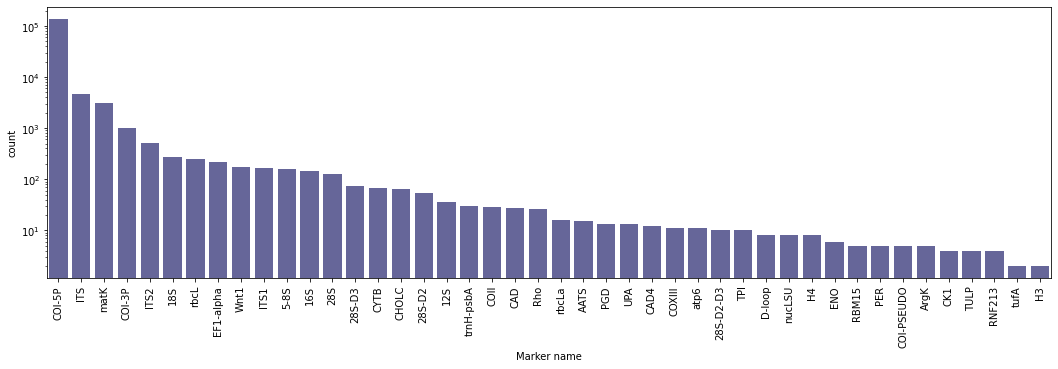

In [4]:
nsr_barcodes = session.query(Barcode).all()
data = [el.marker.marker_name for el in nsr_barcodes]
df = pd.DataFrame(data, columns=['Marker name'])
fig, ax = plt.subplots(figsize=(18,5))
sb.countplot(data=df, x='Marker name', ax=ax, color='b', saturation=0.2, order = df['Marker name'].value_counts().index)
ax.set_yscale('log')
ax.tick_params(axis="x", rotation=90)

<AxesSubplot:xlabel='count', ylabel='Institution'>

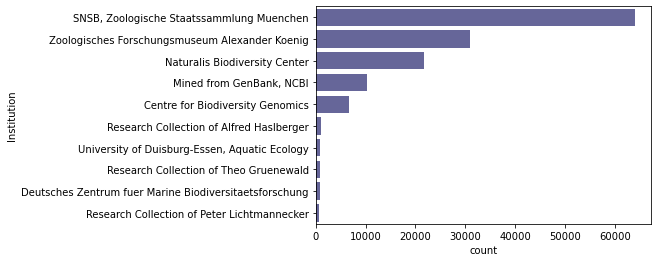

In [5]:
institutions = session.query(Specimen.institution_storing).all()
institutions = [e[0] for e in institutions if e[0]]
df = pd.DataFrame(institutions, columns=['Institution'])
indices = df['Institution'].value_counts().index
sb.countplot(data=df, y='Institution', color='b', saturation=0.2, order = indices[0:10])

In [6]:
# here we fetch the root across all of the Dutch Species Registry
nsr_root = NsrNode.get_root(session)
nsr_kingdoms = NsrNode.get_root(session).get_children(session)
kingdom_root_nodes = { n.name:n for n in nsr_kingdoms.all()[:3] }
print(kingdom_root_nodes)

{'Animalia': <NsrNode(name='9')>, 'Plantae': <NsrNode(name='22')>, 'Fungi': <NsrNode(name='70')>}


'All of life'

In [7]:
# we will now mirror this tree to an object we can draw, collapsing everything below max_rank
max_rank = 'family'
ete_tree_of_life = nsr_root.to_ete(session, until_rank=max_rank, remove_empty_rank=True, remove_incertae_sedis_rank=True)

# because this is a costly traversal we now cache the result so that we can subsequently skip this cell
%store ete_tree_of_life

Stored 'ete_tree_of_life' (TreeNode)


In [8]:
# here we restore the stored tree
%store -r ete_tree_of_life

color_range = ['#FF0000', '#0000FF', '#00FF00', '#FFFF00']  # red, blue, gree, yellow
rank_hierarchy = ['kingdom', 'phylum', 'order', 'class', 'family', 'genus', 'species']

# build an ordered list of highter taxon for the given node leaf
def make_ancestors_list(node):
    l = [None] * rank_hierarchy.index(max_rank)
    for e in node.get_ancestors():
        if not hasattr(e, 'rank') or e.rank == 'life':
            continue
        index = rank_hierarchy.index(e.rank)
        l[rank_hierarchy.index(e.rank)] = e.name
    return l
    

def get_color(value):
    round_value = int(value * 10) // 10
    return color_range[min(round_value, len(color_range) - 1)]

# does postorder traversel, propagating total species and total barcodes from tips to root
def add_count_features(tree, max_rank, species_bc_dict):
    coverage_table = []
    for node in tree.iter_descendants(strategy='postorder'):
        if node.rank == max_rank:
            # print(node.id, node.rank, node.name)
            tips = session.query(NsrNode).filter(NsrNode.id == node.id).first().get_leaves(session).all()
            total_bc = 0
            sp_with_bc = 0
            for tip in tips:
                if tip.species_id and tip.species_id in species_bc_dict:
                    total_bc += species_bc_dict[tip.species_id]
                    sp_with_bc += 1
            node.add_feature('total_sp', len(tips))
            node.add_feature('sp_with_bc', sp_with_bc)
            node.add_feature('total_bc', total_bc)
            
            
            coverage = sp_with_bc/len(tips)*100
            if coverage != 0:
                # get a color from the number of barcode / per species
                color = get_color(math.log10(len(tips)))
                rf = RectFace(coverage*3, 24, color, color)
                node.add_face(rf, column=1, position="aligned")
                # black line to show the max limit of coverage
                rfl = RectFace(2, 40, 'black', 'black') 
                node.add_face(rfl, column=2, position="aligned")
            coverage_table.append(make_ancestors_list(node) + [node.name, len(tips), sp_with_bc, total_bc, coverage])


        else:
            total_sp = 0
            total_bc = 0
            sp_with_bc = 0
            for child in node.get_children():
                total_sp += child.total_sp
                total_bc += child.total_bc
                sp_with_bc += child.sp_with_bc
            node.add_feature('total_sp', total_sp)
            node.add_feature('sp_with_bc', sp_with_bc)
            node.add_feature('total_bc', total_bc)
            
    # finally also do the tree root itself
    total_sp = 0
    total_bc = 0
    sp_with_bc = 0
    for child in tree.get_children():
        total_sp += child.total_sp
        total_bc += child.total_bc
        sp_with_bc += child.sp_with_bc
    tree.add_feature('total_sp', total_sp)
    tree.add_feature('sp_with_bc', sp_with_bc)
    tree.add_feature('total_bc', total_bc)
    
    return coverage_table

    
# prefetches the number of barcodes per species_id as dict
def get_species_barcode_count():
    query = session.query(Specimen.species_id, func.count()).join(Barcode).group_by(Specimen.species_id)
    return { e:c for e, c in query.all() }


def get_species_wo_barcode():
    query = session.query(Specimen.species_id, func.count()).join(Barcode).group_by(Specimen.species_id)
    return { e:c for e, c in query.all() }


def my_layout(node):
    if node.is_leaf():
        if node.name:
            name_face = AttrFace("name", fsize=48)
            name_face.margin_right = 10
            name_face.margin_left = 10
            name_face.hz_align = 2  # right aligned
            faces.add_face_to_node(name_face, node, column=0, position="aligned")
        else:
            return
        
    elif node.name:
        name_face = AttrFace("name", fsize=24, fgcolor="blue", formatter='%-15s')
        name_face.margin_right = 10
        name_face.margin_left = 10
        faces.add_face_to_node(name_face, node, column=0)
    else:
        return

def get_tree_style(title, title_fsize=400, legend_fsize=200):
    circular_style = TreeStyle()
    circular_style.layout_fn = my_layout
    circular_style.mode = "c" # draw tree in circular mode
    circular_style.show_leaf_name = False
    circular_style.draw_guiding_lines = False
    if title and title_fsize != 0:
        circular_style.title.add_face(TextFace(title, fsize=title_fsize), column=0)
    
    # add legend 
    if legend_fsize != 0:
        circular_style.legend.add_face(TextFace("#", fsize=legend_fsize), column=0)
        circular_style.legend.add_face(TextFace("Species count ", fsize=legend_fsize), column=1)
        circular_style.legend.add_face(TextFace("per family", fsize=legend_fsize), column=2)

        i = 0
        range_strs = ["0-9", "10-99","100-999","1000+"]
        for color in color_range:
            rf = RectFace(legend_fsize, legend_fsize, color, color)
            circular_style.legend.add_face(rf, column=0)
            tf = TextFace(range_strs[i], fsize=legend_fsize)
            tf.margin_left = legend_fsize // 2
            circular_style.legend.add_face(tf, column=1)
            i += 1
    # circular_style.force_topology = True
    return circular_style

    
# run the above functions to calculate subtended barcodes/species on all nodes
d = get_species_barcode_count()

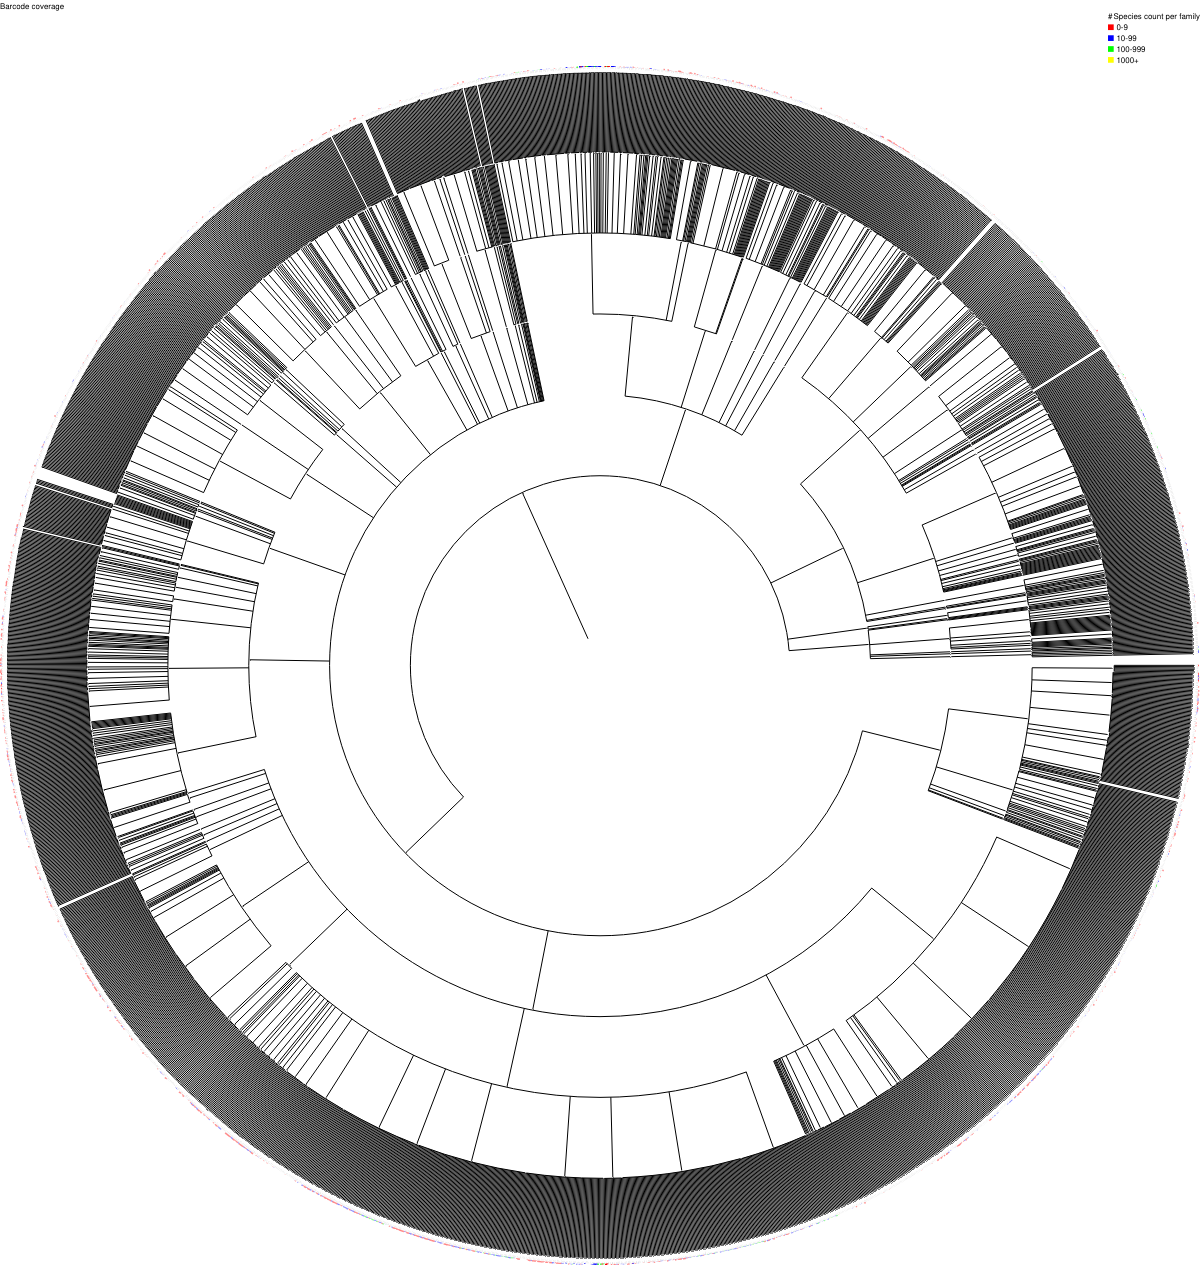

In [27]:
coverage_table = add_count_features(ete_tree_of_life, max_rank, d)
tree_style = get_tree_style("Barcode coverage", 1200, 1200)  # font size > ~1200 is ignoring the whitespace characters?
ete_tree_of_life.render(file_name='%%inline', w=1200, tree_style=tree_style)

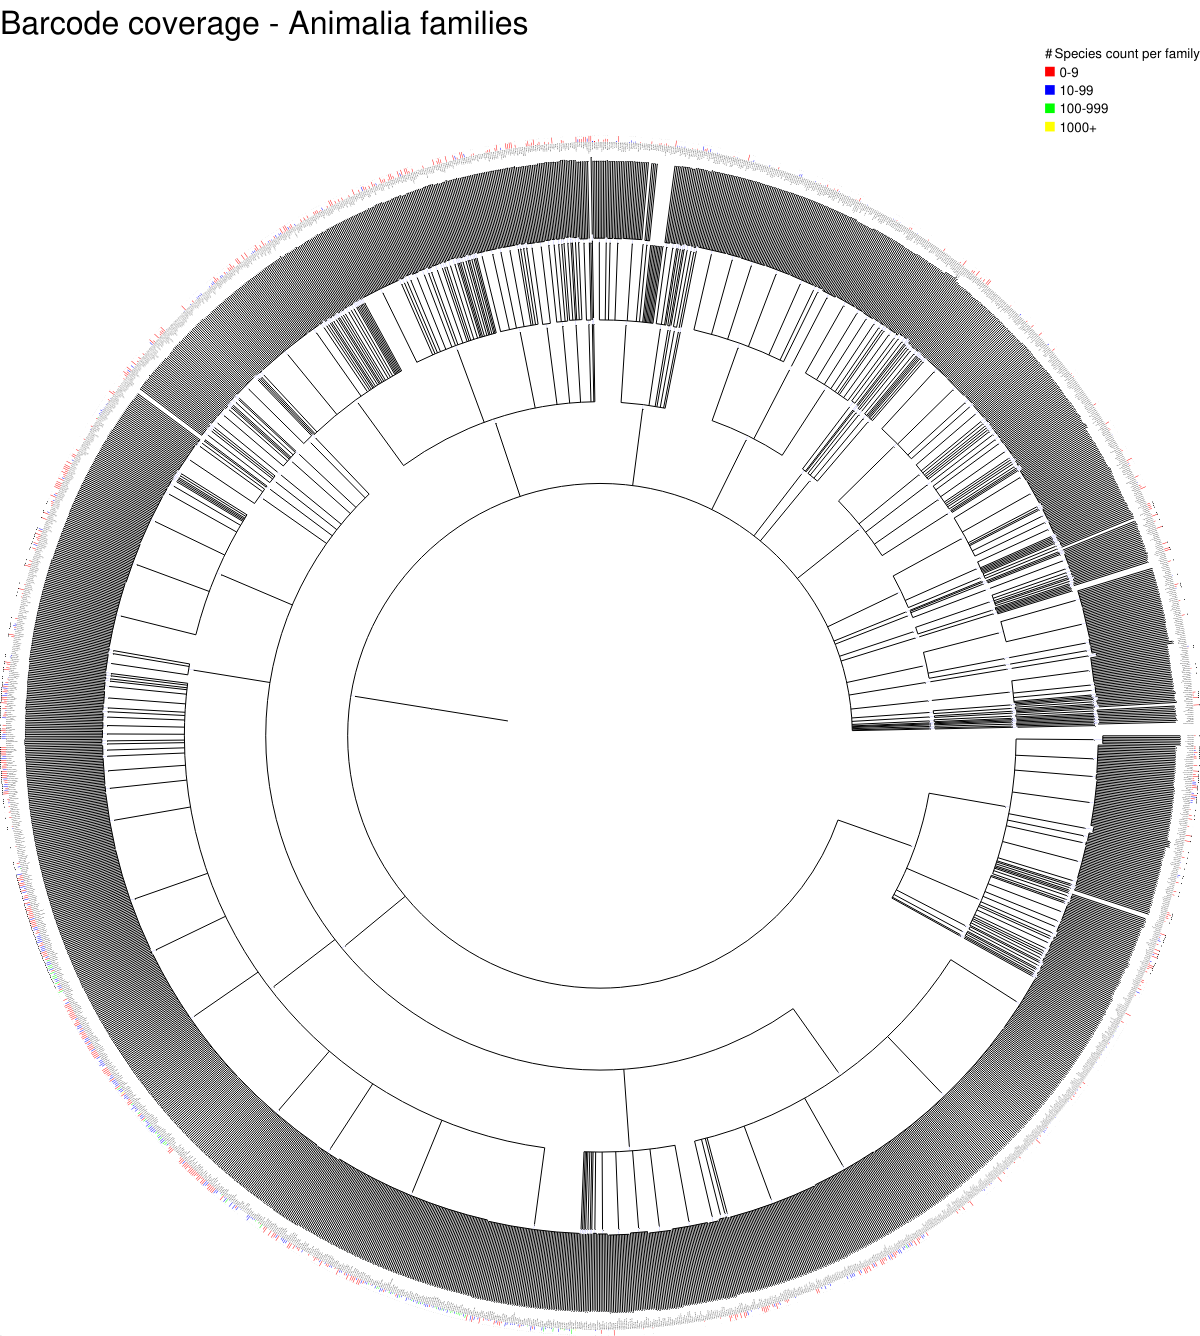

In [10]:
ete_tree_animalia = kingdom_root_nodes['Animalia'].to_ete(session, until_rank=max_rank, remove_empty_rank=True, remove_incertae_sedis_rank=True)
add_count_features(ete_tree_animalia, max_rank, d)
tree_style = get_tree_style("Barcode coverage - Animalia families", 1200, 500)
ete_tree_animalia.render(file_name='%%inline', w=1200, tree_style=tree_style)

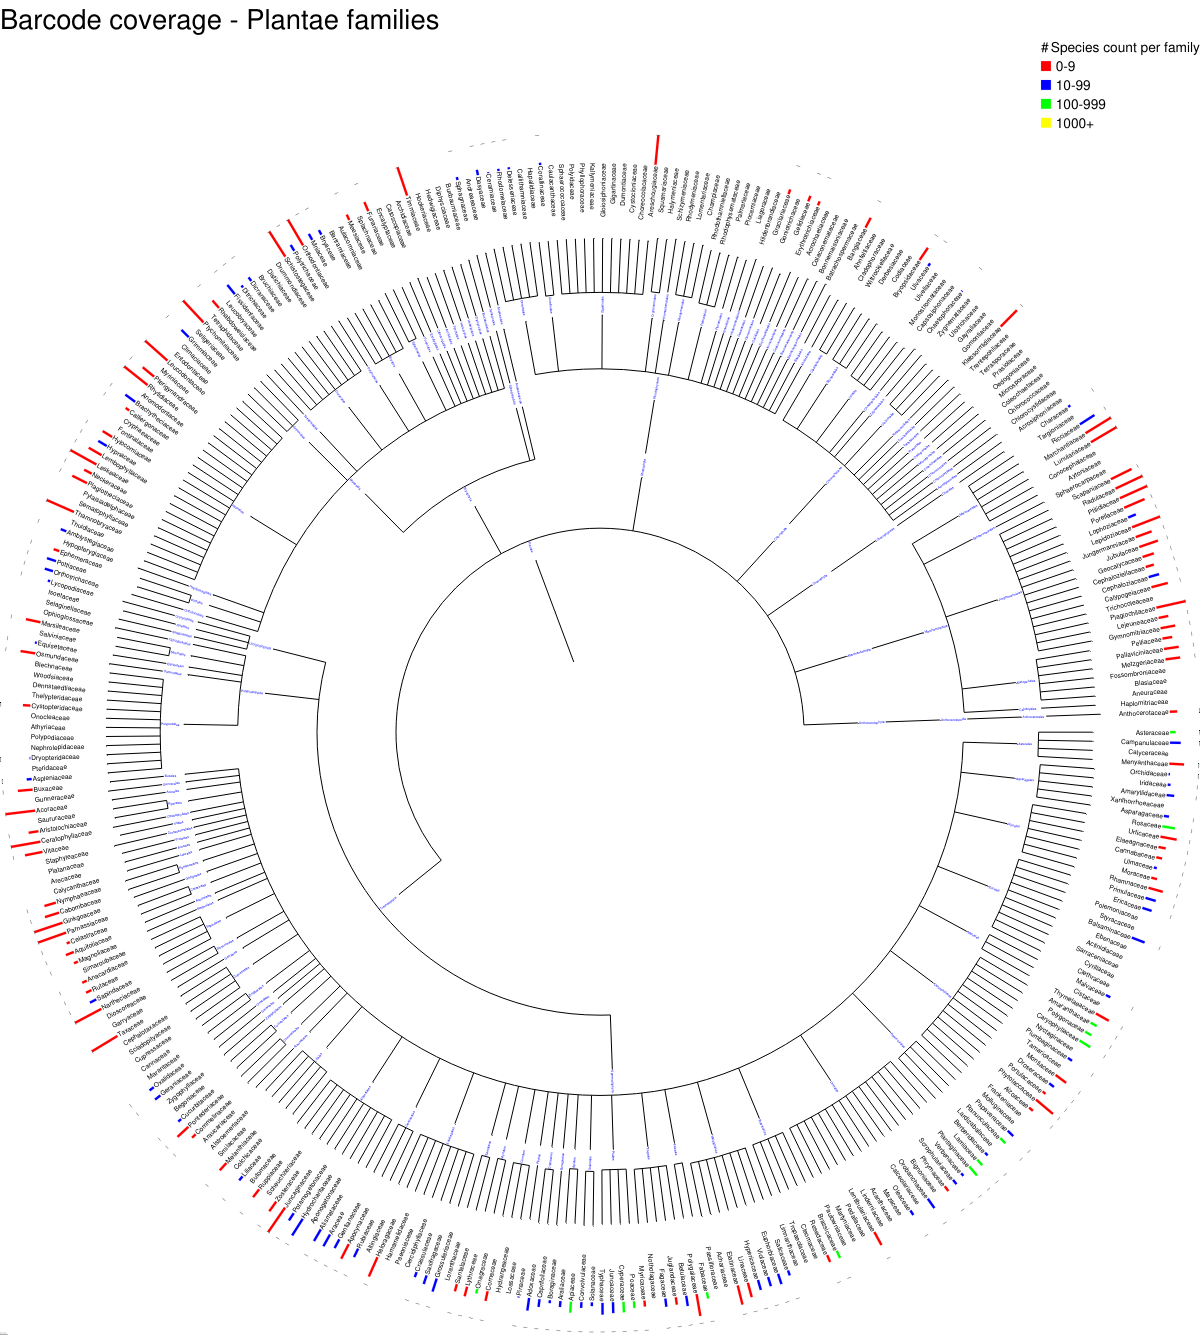

In [11]:
ete_tree_plantae = kingdom_root_nodes['Plantae'].to_ete(session, until_rank=max_rank, remove_empty_rank=True, remove_incertae_sedis_rank=True)
add_count_features(ete_tree_plantae, max_rank, d)
# ete_tree_plantae.convert_to_ultrametric()
tree_style = get_tree_style("Barcode coverage - Plantae families", 200, 100)
ete_tree_plantae.render(file_name='%%inline', w=1200, tree_style=tree_style)

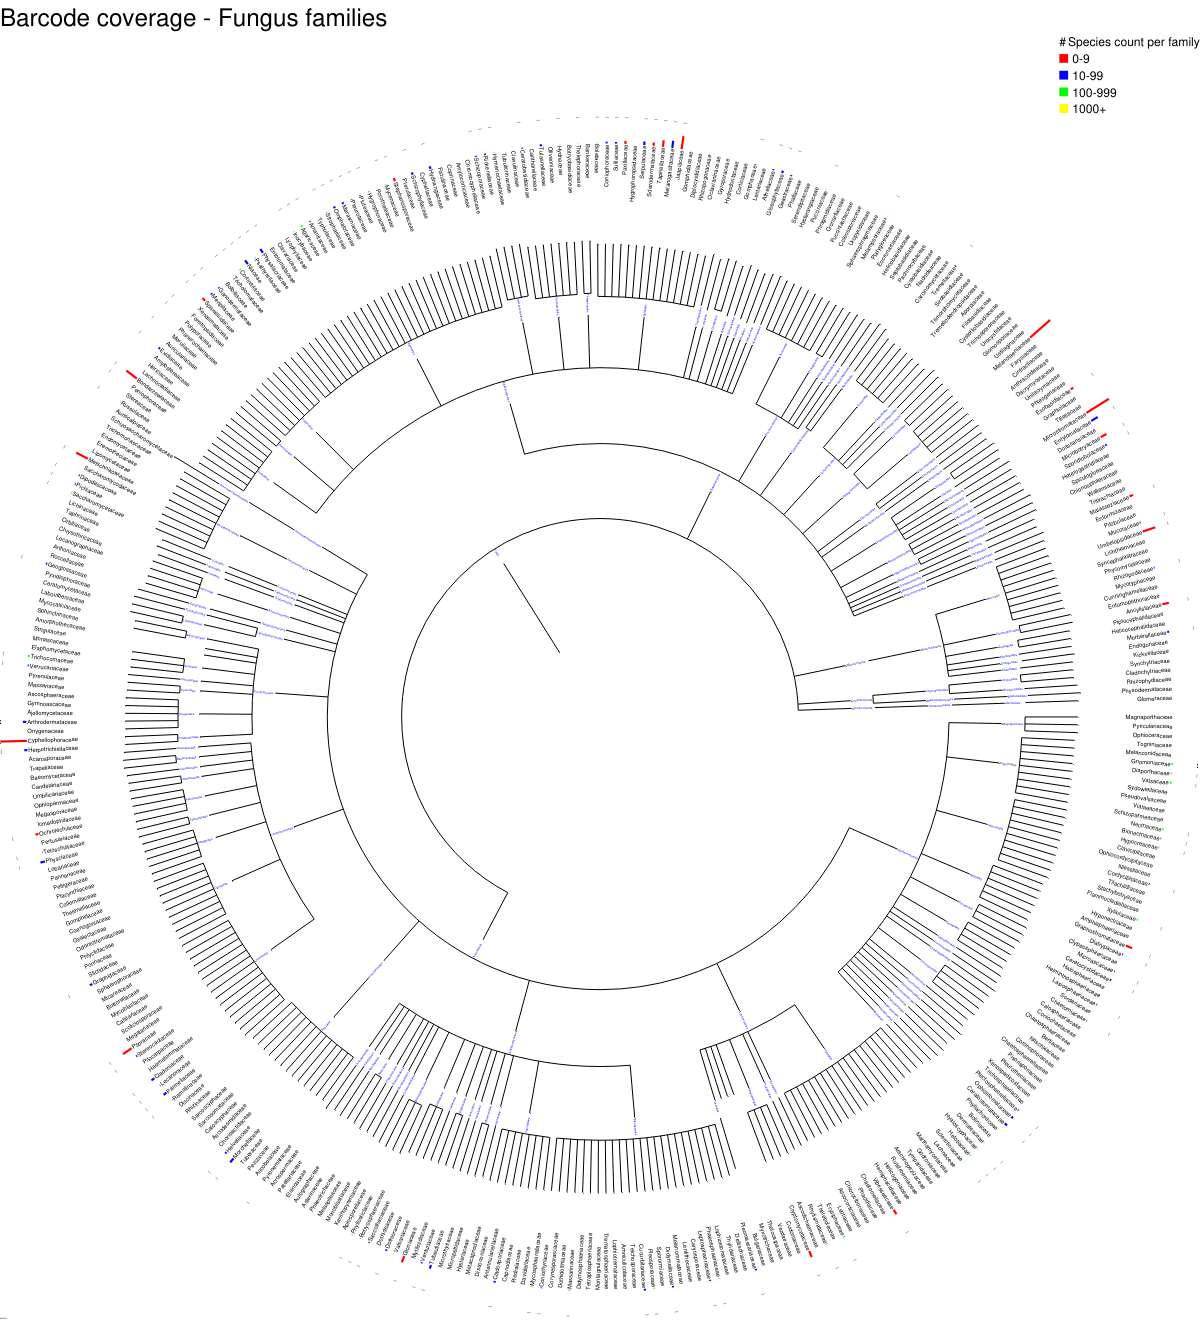

In [12]:
ete_tree_fungi = kingdom_root_nodes['Fungi'].to_ete(session, until_rank=max_rank, remove_empty_rank=True, remove_incertae_sedis_rank=True)
coverage_table_fungi = add_count_features(ete_tree_fungi, max_rank, d)
tree_style = get_tree_style("Barcode coverage - Fungus families", 200, 100)
ete_tree_fungi.render(file_name='%%inline', w=1200, tree_style=tree_style)

In [21]:
df = pd.DataFrame(coverage_table, columns=['kingdom', "phylum", 'order', 'class', "family" , "# species", "# barcoded species","# barcodes in family","% of species barcoded"])
table = qgrid.show_grid(df, precision=2)
table

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [17]:
# This is the part where we have to play with ETE's options to make this cool. Ideas:
# - It should be possible to render the tree only up to a specified level, e.g.
#   'phylum' or 'class'. There are several challenges: 1) we have a lot of 'incertae sedis'
#   that are grafted on anonymous parents, 2) the ETE API behaves inpredictably, I
#   try to prune children below a specified level but nothing seems to happen, 3)
#   there appear to be cycles in the data structure (and database), probably due to
#   faulty DarwinCore output.
# - It should also be possible to render from another node than the root. I think 
#   that might just be matter of finding the right node and rendering from there,
#   e.g. showing all the Molluscs or whatever.
# - Visualizing the features (n tips, n barcodes) is possible through the 'faces',
#   example is here: https://www.biostars.org/p/153788/
# Nice to have but not essential:
# - Color coding would be nice for the clades. A way to do that is use HSV instead
#   of RGB, divide 360 by number of children's descendants (at root), then subdivide 
#   the segments further as you approach the tips.
# - It would be nice if we can collapse unbranched internal nodes, for monotypic
#   higher taxa.